Libraries import and matplotlib setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from policy import Policy
from car import *
from person import *
from environment import Environment
from policy import *

import rtree
import pyproj
import overpy
import shapely
import matplotlib
import geopandas as gpd
import contextily as ctx
from tempfile import mkstemp
from shapely.ops import polygonize
from shapely.wkt import loads as wkt_load
from shapely.geometry import Point, LineString, Polygon, GeometryCollection

from matplotlib import pylab as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.titlesize"] = 16.
plt.rcParams["axes.labelsize"] = 14.
plt.rcParams["xtick.labelsize"] = 12.
plt.rcParams["ytick.labelsize"] = 12.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [8., 5.]

%load_ext autoreload
%autoreload 2

Loading map as a graph

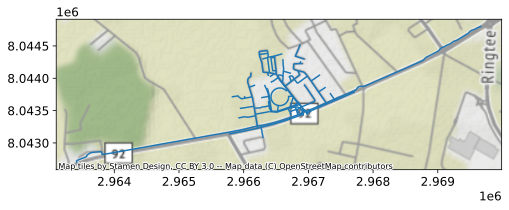

In [2]:
crs_gps = pyproj.CRS.from_epsg('4326')
crs_web = pyproj.CRS.from_epsg('3857')

req = '''area["name"="Märja alevik"]->.a;
  ( node(area.a)["highway"];
    way(area.a)["highway"];
    rel(area.a)["highway"];
  );
  out body;
  >;
  out;
'''

overpass_api = overpy.Overpass()
rsp = overpass_api.query(req)

df_nodes =\
pd.DataFrame([dict([(a,getattr(x,a)) for a in ['id','lat','lon']]) for x in rsp.nodes]).set_index('id',drop=True)
df_nodes

df_ways =\
pd.DataFrame(np.vstack([np.asarray([[w.id, n.id] for n in w.nodes]) for w in rsp.ways]),columns=['id','node'])\
    .set_index('id', drop=True)
df_ways

df_way_lines =\
df_ways.join(df_nodes, on='node')\
    .groupby('id')\
    .apply(lambda df_way: LineString(df_way[['lon','lat']].values))
df_way_lines

gdf_ways = gpd.GeoDataFrame(df_way_lines.index,
                            geometry=df_way_lines.values,
                            crs=crs_gps).set_index('id', drop=True)\
    .to_crs(crs=crs_web)
gdf_ways

fig,ax = plt.subplots(1,1)
gdf_ways.plot(ax=ax)
ctx.add_basemap(ax=ax, zoom=13)

In [3]:
df_edges =\
df_ways.reset_index(drop=False).groupby('id').apply(
    lambda df_nodes: pd.DataFrame(
        np.vstack([df_nodes.node.values[:-1],
                   df_nodes.node.values[1:]]).T))\
    .rename(columns={0:'vtx1',1:'vtx2'})
df_edges
gdf_nodes =\
gpd.GeoDataFrame(
    df_nodes.index,
    geometry=[Point(p) for p in df_nodes[['lon','lat']].values],
    crs=crs_gps).to_crs(crs=crs_web).set_index('id', drop=True)
gdf_nodes

ptx,pty =\
np.array([p.xy for p in gdf_nodes.geometry.values]).reshape(-1,2).T
gdf_nodes['x'] = ptx
gdf_nodes['y'] = pty

src = gdf_nodes.loc[df_edges.vtx1.values][['x','y']].values
dst = gdf_nodes.loc[df_edges.vtx2.values][['x','y']].values

index1 = [(v1, v2) for v1, v2 in zip(df_edges.vtx1.values, df_edges.vtx2.values)]
index2 = [(v2, v1) for v1, v2 in zip(df_edges.vtx1.values, df_edges.vtx2.values)]
df_edges = pd.concat((
    pd.DataFrame({'dst': np.linalg.norm(src-dst, axis=1)}, index=index1), 
    pd.DataFrame({'dst': np.linalg.norm(src-dst, axis=1)}, index=index2), 
))

Distances dict (between each pair of nodes)

In [4]:
distances = pd.DataFrame(
    {'dst': [df_edges.loc[[(v1, v2)]]['dst'].values[0] if (v1, v2) in df_edges.index else np.inf for v1 in df_nodes.index for v2 in df_nodes.index]}, 
    index=[(v1, v2) for v1 in df_nodes.index for v2 in df_nodes.index]
)

Floyd-Warshall

In [5]:
from tqdm.notebook import tqdm

distances = {(v1, v2): df_edges.loc[[(v1, v2)]]['dst'].values[0] / 10 if (v1, v2) in df_edges.index else np.inf for v1 in df_nodes.index for v2 in df_nodes.index}
for v in df_nodes.index:
    distances[v, v] = 0

for k in tqdm(df_nodes.index):
    for v1 in df_nodes.index:
        for v2 in df_nodes.index:
            distances[v1, v2] = min(
                distances[v1, v2], 
                distances[v1, k] + distances[k, v2]
            )

Disconnected components filtering

In [6]:
np.unique(list(distances.values()), return_counts=True)

(array([0.00000000e+00, 2.20796573e-01, 3.18159369e-01, ...,
        6.77284723e+02, 6.79198181e+02,            inf]),
 array([ 408,    2,    2, ...,    2,    2, 4848]))

In [7]:
to_drop_v = set()
for v1 in df_nodes.index:
    count = 0
    for v2 in df_nodes.index:
        if distances[v1, v2] == np.inf:
            count += 1
    if count > 350:
        to_drop_v.add(v1)
to_drop_e = []
for v1, v2 in distances:
    if {v1, v2} & to_drop_v:
        to_drop_e.append((v1, v2))
for pair in to_drop_e:
    del distances[pair]
df_nodes = df_nodes.drop(to_drop_v)

Sample simulation

In [8]:
time = 0
pers_proba = 0.05
nodes = df_nodes.index

car_f = CarFactory()
per_f = PersonFactory()

cars = [car_f.generate_car(nodes, time) for _ in range(10)]
people = [per_f.generate_person(nodes, time), per_f.generate_person(nodes, time)]

policy = DummyPolicy(cars, people, distances)
environment = Environment(cars, people, policy, distances)

while time <= 10 ** 4:
    if np.random.rand() < pers_proba:
        people.append(per_f.generate_person(nodes, time))
    environment.step(time, distances)
    time += 1
    if time % 1000 == 0:
        print(time, 'time units passed')

1000 time units passed
2000 time units passed
3000 time units passed
4000 time units passed
5000 time units passed
6000 time units passed
7000 time units passed
8000 time units passed
9000 time units passed
10000 time units passed


Functions for collecting statistics

In [9]:
def calculate_ratio(policy_class, iterations=10):
    np.random.seed(1337)
    ratios = []
    for _ in range(iterations):
        time = 0
        pers_proba = 0.05
        nodes = df_nodes.index

        car_f = CarFactory()
        per_f = PersonFactory()

        cars = [car_f.generate_car(nodes, time) for _ in range(10)]
        people = [per_f.generate_person(nodes, time), per_f.generate_person(nodes, time)]
        
        policy = policy_class(cars, people, distances)
        environment = Environment(cars, people, policy, distances)

        while time <= 10 ** 4:
            if np.random.rand() < pers_proba:
                people.append(per_f.generate_person(nodes, time))
            environment.step(time, distances)
            time += 1
        _, ratio = environment.stats()
        ratios.append(ratio)
    ratios = np.array(ratios)
    return f'{ratios.mean(): .4f} ±{ratios.std(): .4f}'


def boxplots(policy_class, label):
    np.random.seed(1337)
    time = 0
    pers_proba = 0.05
    nodes = df_nodes.index

    car_f = CarFactory()
    per_f = PersonFactory()

    cars = [car_f.generate_car(nodes, time) for _ in range(10)]
    people = [per_f.generate_person(nodes, time), per_f.generate_person(nodes, time)]
        
    policy = policy_class(cars, people, distances)
    environment = Environment(cars, people, policy, distances)

    while time <= 10 ** 4:
        if np.random.rand() < pers_proba:
            people.append(per_f.generate_person(nodes, time))
        environment.step(time, distances)
        time += 1
    stats, _ = environment.stats()
    sns.boxplot(data=stats).set(title=f'Time boxplots for {label} policy', ylabel='minutes')

Ratios and boxplots for 7 policies

In [10]:
calculate_ratio(DummyPolicy)

' 0.6218 ± 0.0377'

In [11]:
calculate_ratio(QueuePolicy)

' 0.6463 ± 0.0467'

In [12]:
calculate_ratio(NearestPolicy)

' 0.9547 ± 0.0126'

In [13]:
calculate_ratio(DiscountedNearestPolicy)

' 0.9547 ± 0.0077'

In [14]:
calculate_ratio(NearestWithDistPolicy)

' 0.9240 ± 0.0169'

In [15]:
calculate_ratio(DiscountedNearestWithDistPolicy)

' 0.9143 ± 0.0194'

In [16]:
calculate_ratio(WeightedNearestWithDistPolicy)

' 0.9022 ± 0.0205'

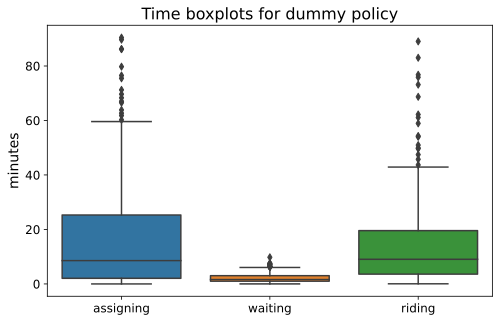

In [17]:
boxplots(DummyPolicy, 'dummy')

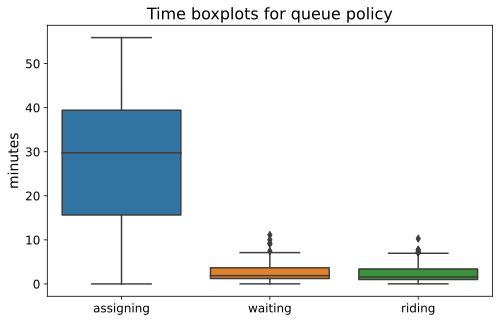

In [18]:
boxplots(QueuePolicy, 'queue')

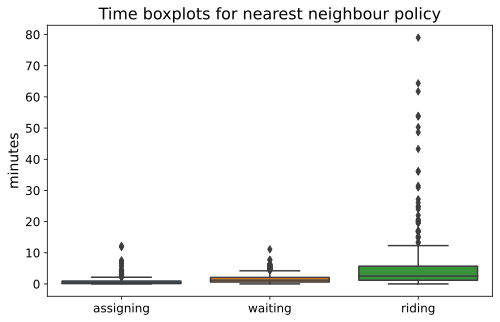

In [19]:
boxplots(NearestPolicy, 'nearest neighbour')

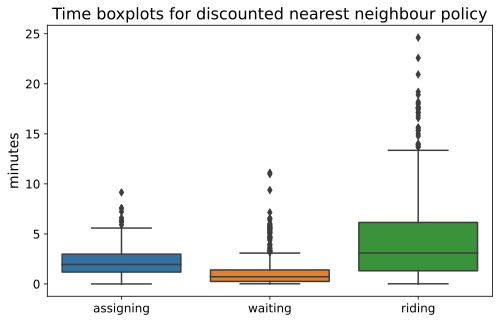

In [20]:
boxplots(DiscountedNearestPolicy, 'discounted nearest neighbour')

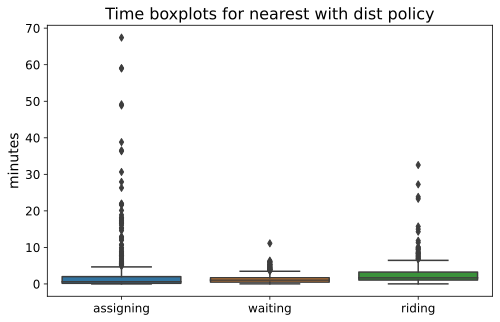

In [21]:
boxplots(NearestWithDistPolicy, 'nearest with dist')

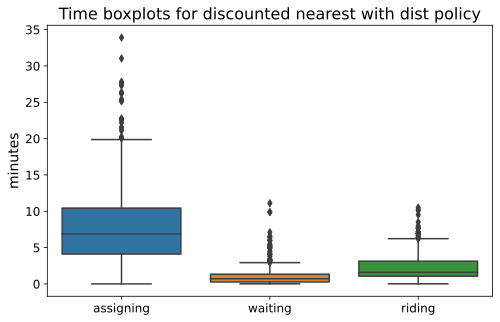

In [22]:
boxplots(DiscountedNearestWithDistPolicy, 'discounted nearest with dist')

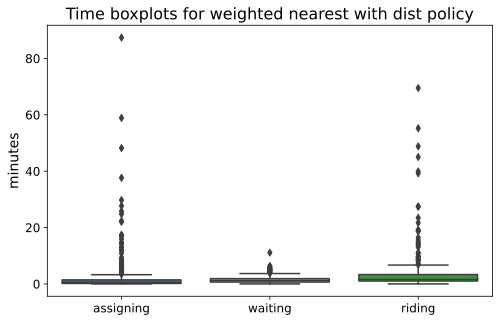

In [23]:
boxplots(WeightedNearestWithDistPolicy, 'weighted nearest with dist')